# Resnet Error Analysis

## Load Dataset

In [1]:
import tensorflow as tf
import cv2
import numpy as np
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import sklearn
import math
import tensorflow_addons as tfa
import pandas as pd
import seaborn as sns

np.set_printoptions(precision=2)
pd.options.display.float_format = "{:,.2f}".format

# Define constants
RANDOM_STATE = 4242
NUM_CLASSES = 9
MAX_EPOCHS = 1000
EARLY_STOPPING_PATIENCE = 50
BASE_LEARNING_RATE = 0.001
BATCH_SIZE = 64

In [2]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds, validation_ds, test_ds = tfds.load('deep_weeds', as_supervised= True, shuffle_files= True, split=["train[:70%]", "train[70%:90%]", "train[90%:100%]"], batch_size = BATCH_SIZE)

print("Number of training samples: %d" % tf.data.experimental.cardinality(train_ds))
print("Number of validation samples: %d" % tf.data.experimental.cardinality(validation_ds))
print("Number of test samples: %d" % tf.data.experimental.cardinality(test_ds))
    
#Pre-Processing
def one_hot(img, label):
    return (img, tf.one_hot(label,9))

train_ds = train_ds.map(one_hot)
validation_ds = validation_ds.map(one_hot)
test_ds = test_ds.map(one_hot)

train_ds = train_ds.shuffle(BATCH_SIZE).prefetch(buffer_size=AUTOTUNE).cache()
validation_ds = validation_ds.shuffle(BATCH_SIZE).prefetch(buffer_size=AUTOTUNE).cache()
test_ds = test_ds.shuffle(BATCH_SIZE).prefetch(buffer_size=AUTOTUNE).cache()

Number of training samples: 192
Number of validation samples: 55
Number of test samples: 28


2021-11-25 09:42:35.855215: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-11-25 09:42:35.865083: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-11-25 09:42:35.865816: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-11-25 09:42:35.866974: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

## Generate Confusion Matrix

In [3]:
model = tf.keras.models.load_model('resnet_finetuned_model')
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 256, 256, 3)]     0         
_________________________________________________________________
random_flip (RandomFlip)     (None, 256, 256, 3)       0         
_________________________________________________________________
random_rotation (RandomRotat (None, 256, 256, 3)       0         
_________________________________________________________________
tf.__operators__.getitem (Sl (None, 256, 256, 3)       0         
_________________________________________________________________
tf.nn.bias_add (TFOpLambda)  (None, 256, 256, 3)       0         
_________________________________________________________________
resnet50 (Functional)        (None, 8, 8, 2048)        23587712  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0     

In [4]:
def loadDatasetEagerly(ds):
    ds_numpy = tfds.as_numpy(ds)
    X_batches = []
    y_batches = []
    for X_batch, y_batch in ds_numpy:
        X_batches.append(X_batch)
        y_batches.append(y_batch)
    X_batches = tuple(X_batches)
    y_batches = tuple(y_batches)
    X = np.concatenate(X_batches, axis = 0)
    y = np.concatenate(y_batches, axis = 0)
    return X, y
    
# Gemerates the confusion matrix, where the row is the actual class label, and the column is the predicted
# class label
def generateConfusionMatrix(model, val_ds):
    # Generate the predictions for the validation set
    X_val, y_val = loadDatasetEagerly(val_ds)
    y_val = np.argmax(y_val, axis=1) # Convert one-hot to index
    y_pred = model.predict(X_val)
    y_pred = np.argmax(y_pred, axis=1) # Convert one-hot to index
    
    # Generate the confusion matrix
    confusion_matrix = np.zeros((NUM_CLASSES, NUM_CLASSES), dtype = np.float64)
    for i in range(len(y_val)):
        predicted = y_pred[i]
        actual = y_val[i]
        confusion_matrix[actual][predicted] += 1
        
    # Convert to % of each class
    _, counts = np.unique(y_val, return_counts = True)
    for row in range(NUM_CLASSES):
        for col in range(NUM_CLASSES):
            confusion_matrix[row][col] /= counts[row]
            confusion_matrix[row][col] *= 100
            
    return pd.DataFrame(confusion_matrix)
    
confusion_matrix = generateConfusionMatrix(model, validation_ds)

2021-11-25 09:42:48.204498: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
2021-11-25 09:42:51.601121: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


Text(0.5, 15.0, 'Predicted')

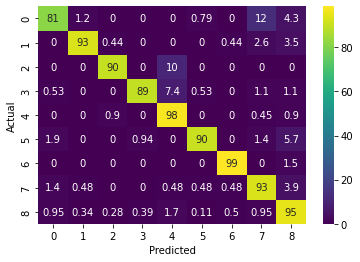

In [5]:
fig = plt.figure(figsize = (8,6))
ax = fig.add_subplot(1,1,1)
sns.heatmap(confusion_matrix, annot = True, cmap='viridis', ax = ax)
ax.set_ylabel("Actual")
ax.set_xlabel("Predicted")